# Fish species classification

## Summary

In this project, I have used pre trained Vgg-16 model to classify a species of fish by following [fast.ai](http://course.fast.ai/) course.

## Things I have learnt from this project

* How to use pre trained model on other datasets.
* How to produce state of art results.

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

In [2]:
# save the path of directories
test_dir = "input/test/"

new_train_dir = "input/new_train/"
new_valid_dir = "input/new_valid/"

In [3]:
classes = os.listdir(new_train_dir)

In [4]:
classes

['LAG', 'OTHER', 'SHARK', 'NoF', 'YFT', 'BET', 'DOL', 'ALB']

In [5]:
train_no = []
valid_no = []
for c in classes:
    train_no.append((len(os.listdir(new_train_dir+c+'/'))))
    valid_no.append(len(os.listdir(new_valid_dir+c+'/')))

In [6]:
sum(train_no)

3019

In [7]:
sum(valid_no)

758

### Checking the validation and train datasets

In [8]:
indexes = [0,1,2,3,4,5,6,7]

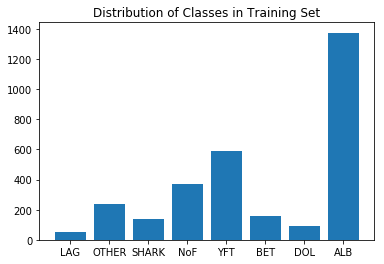

In [9]:
plt.bar(indexes,train_no)
plt.xticks(indexes,classes)
plt.title("Distribution of Classes in Training Set")

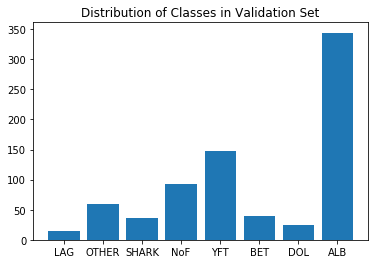

In [10]:
plt.bar(indexes,valid_no)
plt.xticks(indexes,classes)
plt.title("Distribution of Classes in Validation Set")

#### Use a function to save datasets 

In [11]:
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

----------------

In [12]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [13]:
path = "input/"
batch_size=64

In [14]:
from keras.preprocessing import image

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode=None,
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [15]:
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.samples)])

In [16]:
batches = get_batches(path+'new_train', batch_size=batch_size)
val_batches = get_batches(path+'new_valid', batch_size=batch_size*2, shuffle=False)

Found 3019 images belonging to 8 classes.
Found 758 images belonging to 8 classes.


In [17]:
test_batches = get_batches(path+'test',batch_size=1, shuffle=False)

Found 1000 images belonging to 1 classes.


In [18]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = to_categorical(batches.classes)
val_labels = to_categorical(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames
test_filenames = test_batches.filenames

In [19]:
raw_filenames = [f.split('\\')[-1] for f in trn_filenames]
raw_val_filenames = [f.split('\\')[-1] for f in val_filenames]
raw_test_filenames = [f.split('\\')[-1] for f in test_filenames]

In [20]:
batches.samples

3019

### Initial model

In [21]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Model

In [22]:
initial_model = VGG16(weights='imagenet')

553295872/553467096 [============================>.] - ETA: 0s

In [23]:
initial_model.layers.pop()
initial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
#for layer in initial_model.layers: layer.trainable=False

last = initial_model.layers[-1].output
x = Dense(8, activation='softmax')(last)
model = Model(initial_model.input, x)

In [25]:
for layer in model.layers: layer.trainable=False
model.layers[-1].trainable=True

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
trn = get_data(path+'new_train')

Found 3019 images belonging to 8 classes.


In [28]:
val = get_data(path+'new_valid')

Found 758 images belonging to 8 classes.


In [29]:
test = get_data(path+'test')

Found 1000 images belonging to 1 classes.


In [30]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [31]:
save_array(path+'results/test.dat', test)

In [32]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [33]:
test = load_array(path+'results/test.dat')

In [34]:
trn.shape

(3019, 224, 224, 3)

In [35]:
optimizer=Adam()

In [36]:
optimizer.lr = 1e-3

In [37]:
optimizer.lr

0.001

In [38]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(trn, trn_labels, batch_size=batch_size, epochs=3, validation_data=(val, val_labels))

Train on 3019 samples, validate on 758 samples
Epoch 1/3
3019/3019 [==============================] - 68s - loss: 1.3029 - acc: 0.6038 - val_loss: 0.8226 - val_acc: 0.7401
Epoch 2/3
3019/3019 [==============================] - 56s - loss: 0.4827 - acc: 0.8456 - val_loss: 0.4860 - val_acc: 0.8549
Epoch 3/3
3019/3019 [==============================] - 56s - loss: 0.3244 - acc: 0.9026 - val_loss: 0.4171 - val_acc: 0.8760


In [40]:
model.save_weights(path+'results/ft1.h5')

### Precompute convolutional output

In [41]:
model.load_weights(path+'results/ft1.h5')

In [42]:
def split_at(model, layer_type):
    layers = model.layers
    layer_idx = [index for index,layer in enumerate(layers) if type(layer) is layer_type][-1]
    return layers[:layer_idx+1], layers[layer_idx+1:]

In [43]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [44]:
conv_model = Sequential(conv_layers)

In [45]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [46]:
conv_test_feat = conv_model.predict(test)

In [47]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [48]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [49]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [50]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [51]:
conv_val_feat.shape

(758, 14, 14, 512)

### Train model

In [52]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [53]:
p=0.6

In [54]:
optimizer.lr = 1e-3

In [55]:
optimizer.lr

0.001

In [56]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=3, validation_data=(conv_val_feat, val_labels))

Train on 3019 samples, validate on 758 samples
Epoch 1/3
3019/3019 [==============================] - 14s - loss: 1.2494 - acc: 0.6449 - val_loss: 1.6538 - val_acc: 0.7507
Epoch 2/3
3019/3019 [==============================] - 13s - loss: 0.4523 - acc: 0.8758 - val_loss: 0.4385 - val_acc: 0.9011
Epoch 3/3
3019/3019 [==============================] - 13s - loss: 0.2554 - acc: 0.9324 - val_loss: 0.2097 - val_acc: 0.9459


In [58]:
optimizer.lr = 1e-4

In [59]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=7,validation_data=(conv_val_feat, val_labels))

Train on 3019 samples, validate on 758 samples
Epoch 1/7
3019/3019 [==============================] - 13s - loss: 0.1627 - acc: 0.9477 - val_loss: 0.1882 - val_acc: 0.9551
Epoch 2/7
3019/3019 [==============================] - 13s - loss: 0.1128 - acc: 0.9669 - val_loss: 0.1903 - val_acc: 0.9499
Epoch 3/7
3019/3019 [==============================] - 13s - loss: 0.0602 - acc: 0.9815 - val_loss: 0.1530 - val_acc: 0.9644
Epoch 4/7
3019/3019 [==============================] - 13s - loss: 0.0507 - acc: 0.9851 - val_loss: 0.1634 - val_acc: 0.9591
Epoch 5/7
3019/3019 [==============================] - 13s - loss: 0.0458 - acc: 0.9894 - val_loss: 0.1741 - val_acc: 0.9551
Epoch 6/7
3019/3019 [==============================] - 13s - loss: 0.0316 - acc: 0.9917 - val_loss: 0.1672 - val_acc: 0.9670
Epoch 7/7
3019/3019 [==============================] - 13s - loss: 0.0336 - acc: 0.9917 - val_loss: 0.1834 - val_acc: 0.9644


In [60]:
bn_model.save_weights(path+'results/conv_512_6.h5')

In [61]:
bn_model.evaluate(conv_val_feat, val_labels)

758/758 [==============================] - 2s     


[0.183362925360053, 0.96437994848769704]

In [62]:
bn_model.load_weights(path+'results/conv_512_6.h5')